# Simulation using Concord

In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import numpy as np
import scanpy as sc
import time
from pathlib import Path
import torch
import concord as ccd
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

from matplotlib import font_manager, rcParams
custom_rc = {
    'font.family': 'Arial',  # Set the desired font for this plot
}

mpl.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['pdf.fonttype'] = 42

In [3]:
proj_name = "simulation_cluster_partialoverlap"
save_dir = f"../save/dev_{proj_name}-{time.strftime('%b%d')}/"
save_dir = Path(save_dir)
save_dir.mkdir(parents=True, exist_ok=True)

data_dir = f"../data/{proj_name}/"
data_dir = Path(data_dir)
data_dir.mkdir(parents=True, exist_ok=True)
device = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')
print(device)
seed = 0
ccd.ul.set_seed(seed)

file_suffix = f"{time.strftime('%b%d-%H%M')}"
file_suffix

cpu


'Jul24-1648'

In [4]:
concord_methods = ['concord_hcl', 'concord_knn', 'contrastive']
other_methods = [
        "unintegrated",
        "scanorama", "liger", "harmony",
        "scvi", 
]
run_methods = concord_methods + other_methods
# exclude ["UMAP", "t-SNE"] from run_method, and save as combined_keys
exclude_keys = ["PCA", "UMAP", "t-SNE"]
combined_keys = ['no_noise', 'wt_noise'] + [key for key in run_methods if key not in exclude_keys]

In [5]:
state_key = 'cluster'
batch_key = 'batch'
state_type = 'cluster'
leiden_key='leiden'
batch_type = 'batch_specific_features'
distribution = 'normal'
n_cells = [800,600,200,100,50]
n_genes = [600,600,200,100,50]
state_dispersion = [5.0,4.0,4.0,3.0,2.0]

In [6]:
from concord.simulation import (
    SimConfig, ClusterConfig, BatchConfig, Simulation
)

seed = 42                     # or whatever you used earlier

# ───────────────────────────────────── SimConfig ──
sim_cfg = SimConfig(
    n_cells=n_cells,                # one entry per cluster
    n_genes=n_genes,                # one entry per cluster
    seed=seed,
    non_neg=True,
    to_int=True,
)

# ─────────────────────────────────── ClusterConfig ──
state_cfg = ClusterConfig(
    n_states=5,
    distribution="normal",
    level=5.0,                # state_level
    min_level=0.0,            # state_min_level
    dispersion=[5.0, 4.0, 4.0, 3.0, 2.0],
    program_structure="uniform",
    program_on_time_fraction=0.3,
    global_non_specific_gene_fraction=0.10,
    pairwise_non_specific_gene_fraction={
        (0, 1): 0.7,
        (2, 3): 0.4,
        # all other pairs → 0.0, so omit them for brevity
    },
)

# ──────────────────────────────────── BatchConfig ──
batch_cfg = BatchConfig(
    n_batches=2,
    effect_type="batch_specific_features",
    distribution="normal",
    level=[5, 5],
    dispersion=[3.0, 3.0],
    feature_frac=0.1,            # batch_feature_frac
    cell_proportion=[0.5, 0.5],  # proportion of cells in each batch
)

# ─────────────────────────────────── Simulation ──
sim = Simulation(sim_cfg, state_cfg, batch_cfg)

adata_state = sim.simulate_state()
print(f"Simulated data shape: {adata_state.shape}")

concord.simulation.simulation - INFO - Adding non-specific genes to the expression matrix. Note this will increase gene count compared to the specified value.
Simulated data shape: (1750, 1550)


In [25]:
# Define cell indices for each batch, with partial overlap
batch1_clusters = ['cluster_'+str(i) for i in [1,2,3]]
batch2_clusters = ['cluster_'+str(i) for i in [2,3,4,5]]

batch_cell_proportion = 0.3
batch_cell_count = int(adata_state.n_obs * batch_cell_proportion)
print(f"Batch cell count: {batch_cell_count}")
batch1_idx = np.random.choice(adata_state.obs.query(f"{state_key} in {batch1_clusters}").index, batch_cell_count, replace=False)
batch2_idx = np.random.choice(adata_state.obs.query(f"{state_key} in {batch2_clusters}").index, batch_cell_count, replace=False)
print(len(batch1_idx), len(batch2_idx))
batch_indices = {0:ccd.ul.sort_string_list(batch1_idx), 1:ccd.ul.sort_string_list(batch2_idx)}

Batch cell count: 315
315 315


In [26]:
batch_list, state_list = [], []
for i in range(len(batch_indices)):
    batch_adata_pre = adata_state[batch_indices[i]].copy()
    batch_adata = sim.simulate_batch(
        batch_adata_pre,
        batch_idx=i)
    batch_list.append(batch_adata)
    state_list.append(batch_adata_pre)

adata = sim._finalize_anndata(batch_list, join='outer')
adata_state = sim._finalize_anndata(state_list, join='outer')


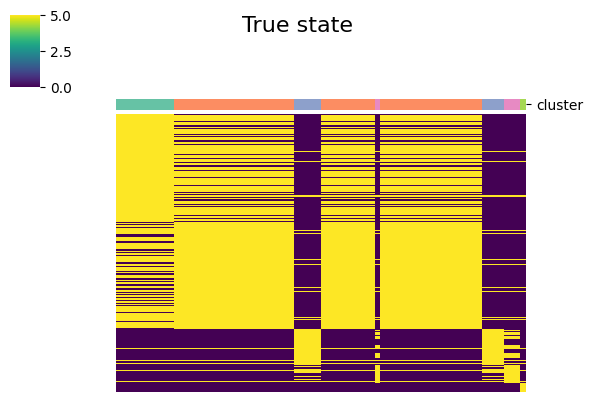

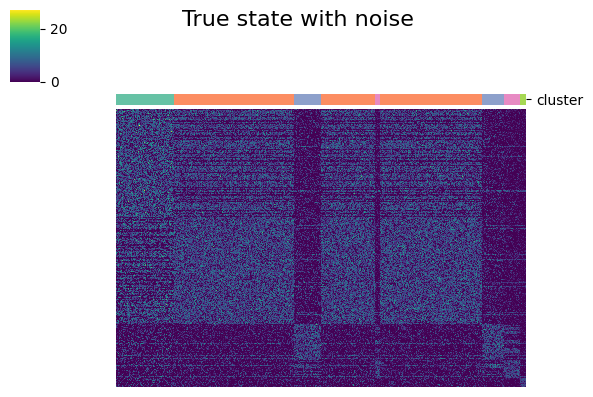

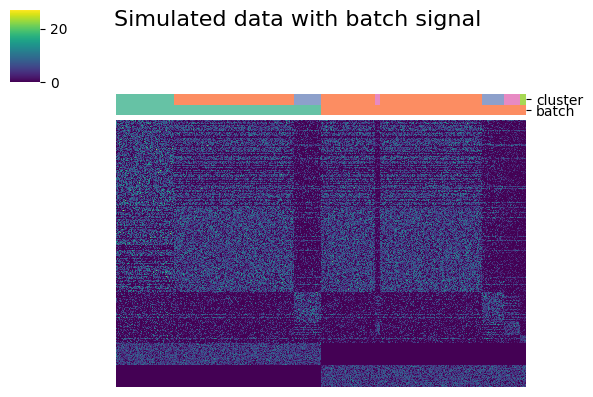

In [27]:
ccd.pl.heatmap_with_annotations(adata_state, val='no_noise', obs_keys=[state_key], yticklabels=False, cluster_cols=False, cluster_rows=False, value_annot=False, cmap='viridis', title='True state', save_path=save_dir/f'true_state_heatmap_{file_suffix}.png', figsize=(6, 4), dpi=300)
ccd.pl.heatmap_with_annotations(adata_state, val='wt_noise', obs_keys=[state_key], yticklabels=False, cluster_cols=False, cluster_rows=False, value_annot=False, cmap='viridis', title='True state with noise', save_path=save_dir/f'true_state_with_noise_heatmap_{file_suffix}.png', figsize=(6, 4), dpi=300)
ccd.pl.heatmap_with_annotations(adata, val='X', obs_keys=[state_key, batch_key], yticklabels=False, cluster_cols=False, cluster_rows=False, value_annot=False, cmap='viridis', title='Simulated data with batch signal', save_path=save_dir/f'simulated_data_heatmap_{file_suffix}.png', figsize=(6, 4), dpi=300)

### Integration pipeline

In [11]:
run_methods = concord_methods + other_methods
run_methods = concord_methods
latent_dim = 15

In [12]:
# Add ground truth
ccd.ul.run_pca(adata_state, source_key='no_noise', result_key='PCA_no_noise', n_pc=latent_dim, random_state=seed)
ccd.ul.run_pca(adata_state, source_key='wt_noise', result_key='PCA_wt_noise', n_pc=latent_dim, random_state=seed)
# Put the PCA result in the adata object, so only one object is needed
adata.obsm['no_noise'] = adata_state.obsm['PCA_no_noise']
adata.obsm['wt_noise'] = adata_state.obsm['PCA_wt_noise']
ccd.ul.run_umap(adata, source_key='no_noise', result_key='no_noise_UMAP', n_components=2, random_state=seed)
ccd.ul.run_umap(adata, source_key='wt_noise', result_key='wt_noise_UMAP', n_components=2, random_state=seed)

concord - INFO - PCA performed on source data with 15 components
concord - INFO - PCA embedding stored in adata.obsm['PCA_no_noise']
concord - INFO - PCA performed on source data with 15 components
concord - INFO - PCA embedding stored in adata.obsm['PCA_wt_noise']


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


concord - INFO - UMAP embedding stored in adata.obsm['no_noise_UMAP']
concord - INFO - UMAP embedding stored in adata.obsm['wt_noise_UMAP']


In [22]:
concord_kwargs = {
    'batch_size': 32,
    'n_epochs': 15,
    'element_mask_prob': 0.4,
    'feature_mask_prob': 0.2,  # Probability of masking a feature
    'encoder_dims': [64],
    'clr_temperature': 0.3,
    'load_data_into_memory': True,
    'verbose': False,
}
profile_logs = ccd.bm.run_integration_methods_pipeline(
    adata=adata,                          
    methods=run_methods,            # List of methods to run
    batch_key=batch_key,                    # Column in adata.obs for batch info
    count_layer="counts",                 # Layer name containing raw counts
    class_key=state_key,               # Column in adata.obs for class labels (used in SCANVI and CONCORD variants)
    latent_dim=latent_dim,                        # Latent dimensionality for PCA and embeddings
    device="cpu",                        # Or "cpu", or "mps" for Apple Silicon
    return_corrected=False,                   # Whether to store corrected expression matrices
    transform_batch=None,                 # Optionally specify a batch to transform to in scVI
    seed=seed,                              # Random seed for reproducibility
    compute_umap=False,                        # Run UMAP for all output embeddings
    umap_n_components=2,
    umap_n_neighbors=30,
    umap_min_dist=0.5,
    verbose=True,                        # Print progress messages
    save_dir=save_dir,
    concord_kwargs=concord_kwargs,
)


concord - WARNING - save_dir is None. Model and log files will not be saved.
concord - WARNING - Input data in adata.X appears to be raw counts. CONCORD performs best on normalized and log-transformed data. Consider setting normalize_total=True and log1p=True.
concord - WARNING - No input feature list provided. It is recommended to first select features using the command `concord.ul.select_features()`.
Epoch 0 Training
Epoch 1 Training
concord - WARNING - FAISS not found. Using sklearn for k-NN computation.
Epoch 2 Training
Epoch 3 Training
Epoch 4 Training
Epoch 5 Training
Epoch 6 Training
Epoch 7 Training
Epoch 8 Training
Epoch 9 Training
Epoch 10 Training
Epoch 11 Training
Epoch 12 Training
Epoch 13 Training
Epoch 14 Training
concord - WARNING - save_dir is None. Skipping model/config saving.


concord_knn: 0.72s | 7.45 MB RAM | 0.00 MB VRAM


concord - WARNING - save_dir is None. Model and log files will not be saved.
concord - WARNING - Input data in adata.X appears to be raw counts. CONCORD performs best on normalized and log-transformed data. Consider setting normalize_total=True and log1p=True.
concord - WARNING - No input feature list provided. It is recommended to first select features using the command `concord.ul.select_features()`.
Epoch 0 Training
Epoch 1 Training
Epoch 2 Training
Epoch 3 Training
Epoch 4 Training
Epoch 5 Training
Epoch 6 Training
Epoch 7 Training
Epoch 8 Training
Epoch 9 Training
Epoch 10 Training
Epoch 11 Training
Epoch 12 Training
Epoch 13 Training
Epoch 14 Training
concord - WARNING - save_dir is None. Skipping model/config saving.


concord_hcl: 0.78s | 7.48 MB RAM | 0.00 MB VRAM


concord - WARNING - save_dir is None. Model and log files will not be saved.
concord - WARNING - Input data in adata.X appears to be raw counts. CONCORD performs best on normalized and log-transformed data. Consider setting normalize_total=True and log1p=True.
concord - WARNING - No input feature list provided. It is recommended to first select features using the command `concord.ul.select_features()`.
concord - WARNING - domain/batch information not found, all samples will be treated as from single domain/batch.
concord - WARNING - Only one domain found in the data. Setting p_intra_domain to 1.0.
Epoch 0 Training
Epoch 1 Training
Epoch 2 Training
Epoch 3 Training
Epoch 4 Training
Epoch 5 Training
Epoch 6 Training
Epoch 7 Training
Epoch 8 Training
Epoch 9 Training
Epoch 10 Training
Epoch 11 Training
Epoch 12 Training
Epoch 13 Training
Epoch 14 Training
concord - WARNING - save_dir is None. Skipping model/config saving.


contrastive: 0.69s | 0.00 MB RAM | 0.00 MB VRAM
✅ All selected methods completed.


In [23]:
for basis in run_methods:
    print("Running UMAP for", basis)
    #if 'UMAP' not in basis:
    ccd.ul.run_umap(adata, source_key=basis, result_key=f'{basis}_UMAP', n_components=2, n_neighbors=30, min_dist=0.5, metric='euclidean', random_state=seed)

Running UMAP for concord_hcl
Running UMAP for concord_knn
Running UMAP for contrastive


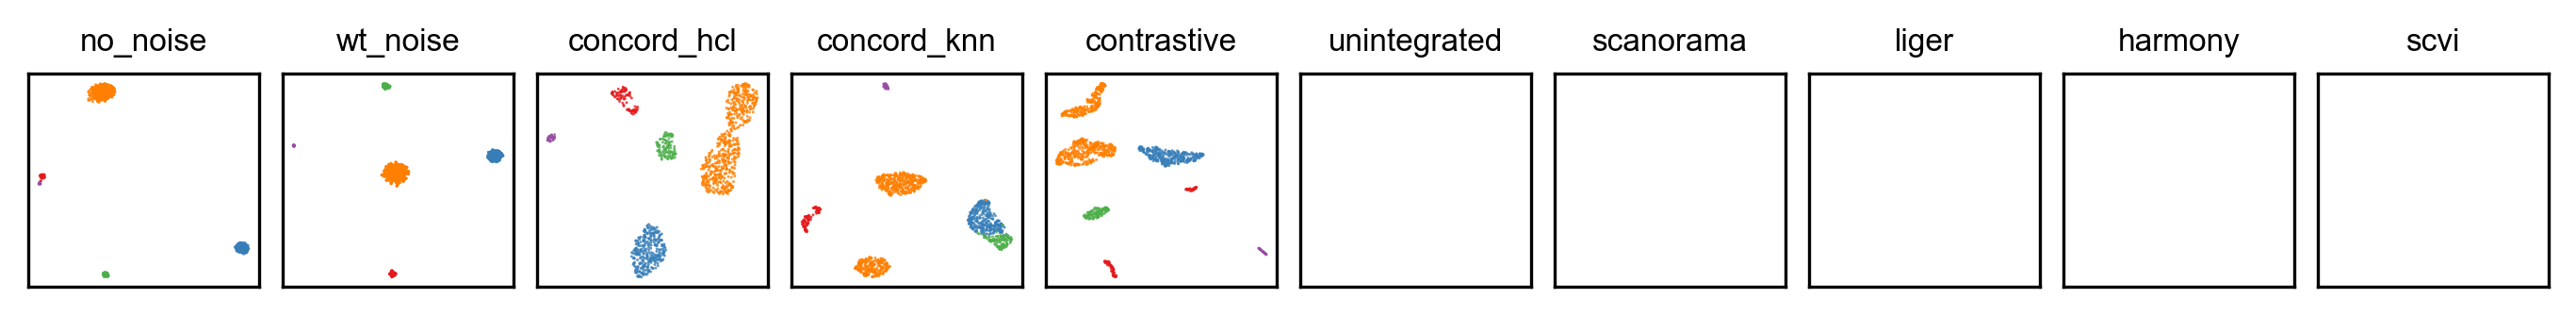

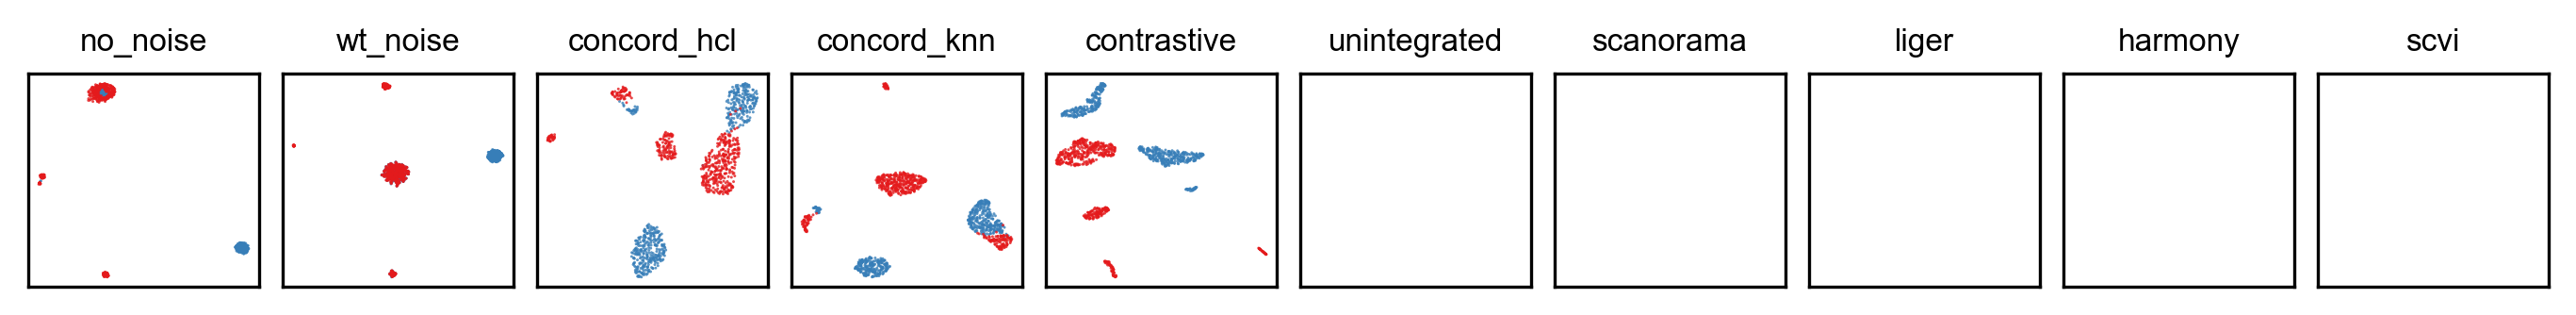

In [24]:
# plot everything
import matplotlib.pyplot as plt

show_keys = combined_keys
# check which methods are run successfully
color_bys = [state_key, batch_key]
basis_types = ['UMAP']
#basis_types = ['KNN']
font_size=8
point_size=2
alpha=0.8
figsize=(0.9*len(show_keys),1)
ncols = len(show_keys)
nrows = int(np.ceil(len(show_keys) / ncols))
pal = {'time':'viridis', 'batch':'Set1'}
k=15
edges_color='grey'
edges_width=0
layout='kk'
threshold = 0.1
node_size_scale=0.1
edge_width_scale=0.1

rasterized = True
with plt.rc_context(rc=custom_rc):
    ccd.pl.plot_all_embeddings(
        adata,
        show_keys,
        color_bys=color_bys,
        basis_types=basis_types,
        pal=pal,
        k=k,
        edges_color=edges_color,
        edges_width=edges_width,
        layout=layout,
        threshold=threshold,
        node_size_scale=node_size_scale,
        edge_width_scale=edge_width_scale,
        font_size=font_size,
        point_size=point_size,
        alpha=alpha,
        rasterized=rasterized,
        figsize=figsize,
        ncols=ncols,
        seed=seed,
        leiden_key='leiden',
        save_dir=save_dir,
        file_suffix=file_suffix+f'rasterized_{rasterized}',
        save_format='svg'
    )


In [100]:
# Find the indices of common genes between `adata` and `adata_state`
# sort and smooth the signal along the path
batch_id=adata.obs['batch'].unique()[0]
batch_indices = np.where(adata.obs['batch'] == batch_id)[0]
_, _, _, feature_order = ccd.ul.sort_and_smooth_signal_along_path(adata, signal_key='concord_knn', path=batch_indices, sigma=2)
adata.obsm['concord_knn_sorted'] = adata.obsm['concord_knn'][:, feature_order]
_, _, _, feature_order = ccd.ul.sort_and_smooth_signal_along_path(adata, signal_key='concord_hcl', path=batch_indices, sigma=2)
adata.obsm['concord_hcl_sorted'] = adata.obsm['concord_hcl'][:, feature_order]


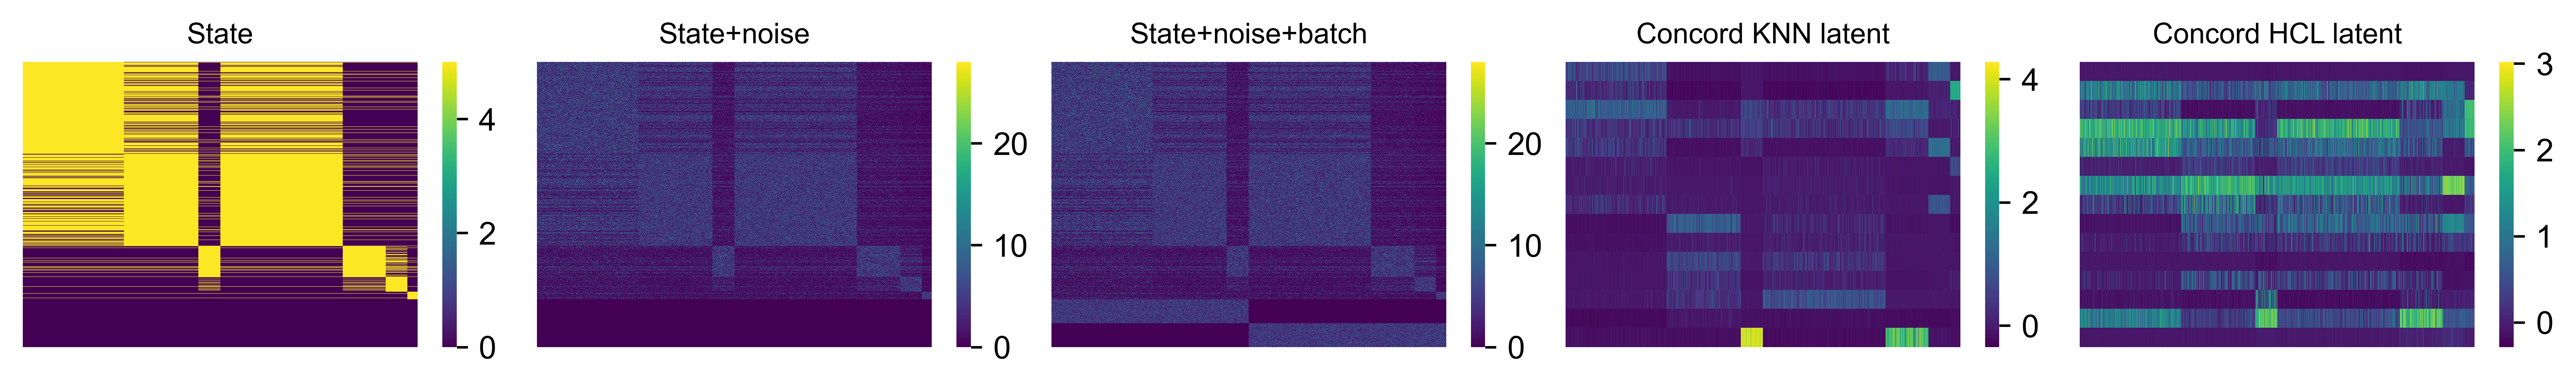

In [101]:
# Plot heatmap of original data and Concord latent
import matplotlib.pyplot as plt
figsize = (2.3, 1.8)
ncols = 5
title_fontsize = 9
_, _, state_pal = ccd.pl.get_color_mapping(adata, state_key, pal='Paired', seed=seed)
_, _, batch_pal = ccd.pl.get_color_mapping(adata, batch_key, pal='Set1', seed=seed)
pal = {state_key: state_pal, batch_key: batch_pal}
dpi = 600
with plt.rc_context(rc=custom_rc):
    fig, axes = plt.subplots(1, ncols, figsize=(figsize[0] * ncols, figsize[1]), dpi=dpi)
    ccd.pl.heatmap_with_annotations(adata, val='no_noise', obs_keys=[state_key], ax = axes[0], use_clustermap=False, pal=pal, yticklabels=False, cluster_cols=False, cluster_rows=False, value_annot=False, cmap='viridis', title='State', save_path=None, figsize=figsize, dpi=dpi, title_fontsize=title_fontsize)
    ccd.pl.heatmap_with_annotations(adata, val='wt_noise', obs_keys=[state_key], ax = axes[1], use_clustermap=False, pal=pal, yticklabels=False, cluster_cols=False, cluster_rows=False, value_annot=False, cmap='viridis', title='State+noise', save_path=None, figsize=figsize, dpi=dpi, title_fontsize=title_fontsize)
    ccd.pl.heatmap_with_annotations(adata, val='X', obs_keys=[state_key, batch_key], ax = axes[2], use_clustermap=False, pal=pal, yticklabels=False, cluster_cols=False, cluster_rows=False, value_annot=False, cmap='viridis', title='State+noise+batch', save_path=None, figsize=figsize, dpi=dpi, title_fontsize=title_fontsize)
    ccd.pl.heatmap_with_annotations(adata, val='concord_knn_sorted', obs_keys=[state_key, batch_key], ax = axes[3], use_clustermap=False, pal=pal, yticklabels=False, cluster_cols=False, cluster_rows=False, value_annot=False, cmap='viridis', title='Concord KNN latent', save_path=None, figsize=figsize, dpi=dpi, title_fontsize=title_fontsize)
    ccd.pl.heatmap_with_annotations(adata, val='concord_hcl_sorted', obs_keys=[state_key, batch_key], ax = axes[4], use_clustermap=False, pal=pal, yticklabels=False, cluster_cols=False, cluster_rows=False, value_annot=False, cmap='viridis', title='Concord HCL latent', save_path=None, figsize=figsize, dpi=dpi, title_fontsize=title_fontsize)
    plt.tight_layout(w_pad=0.0, h_pad=0.1)
    plt.savefig(save_dir / f"all_heatmaps_{file_suffix}.svg", dpi=dpi, bbox_inches='tight')

In [102]:
# Save result
adata.write_h5ad(data_dir / f"adata_{file_suffix}.h5ad", compression='gzip')
adata_state.write_h5ad(data_dir / f"adata_state_{file_suffix}.h5ad", compression='gzip')
print(f"Saved adata to {data_dir / f'adata_{file_suffix}.h5ad'}")
print(f"Saved adata_state to {data_dir / f'adata_state_{file_suffix}.h5ad'}")

Saved adata to ../data/simulation_cluster_partialoverlap/adata_Jul24-1528.h5ad
Saved adata_state to ../data/simulation_cluster_partialoverlap/adata_state_Jul24-1528.h5ad


# Evaluation

In [103]:

# adata = sc.read(data_dir / f"adata_Nov29-1033.h5ad")
# adata_state = sc.read(data_dir / f"adata_state_Nov29-1033.h5ad")
adata = sc.read(data_dir / f"adata_Jul24-1528.h5ad")
adata.shape

(1400, 1860)

Embeddings:   0%|          | 0/10 [00:00<?, ?it/s]

INFO     cluster_1 consists of a single batch or is too small. Skip.                                               
INFO     cluster_4 consists of a single batch or is too small. Skip.                                               
INFO     cluster_5 consists of a single batch or is too small. Skip.                                               


Embeddings:  10%|█         | 1/10 [00:02<00:20,  2.30s/it]

INFO     cluster_1 consists of a single batch or is too small. Skip.                                               
INFO     cluster_4 consists of a single batch or is too small. Skip.                                               
INFO     cluster_5 consists of a single batch or is too small. Skip.                                               


Embeddings:  20%|██        | 2/10 [00:02<00:09,  1.23s/it]

INFO     cluster_1 consists of a single batch or is too small. Skip.                                               
INFO     cluster_4 consists of a single batch or is too small. Skip.                                               
INFO     cluster_5 consists of a single batch or is too small. Skip.                                               


Embeddings:  30%|███       | 3/10 [00:03<00:06,  1.14it/s]

INFO     cluster_1 consists of a single batch or is too small. Skip.                                               
INFO     cluster_4 consists of a single batch or is too small. Skip.                                               
INFO     cluster_5 consists of a single batch or is too small. Skip.                                               


Embeddings:  40%|████      | 4/10 [00:03<00:04,  1.43it/s]

INFO     cluster_1 consists of a single batch or is too small. Skip.                                               
INFO     cluster_4 consists of a single batch or is too small. Skip.                                               
INFO     cluster_5 consists of a single batch or is too small. Skip.                                               


Embeddings:  50%|█████     | 5/10 [00:04<00:02,  1.70it/s]

INFO     cluster_1 consists of a single batch or is too small. Skip.                                               
INFO     cluster_4 consists of a single batch or is too small. Skip.                                               
INFO     cluster_5 consists of a single batch or is too small. Skip.                                               


Embeddings:  60%|██████    | 6/10 [00:04<00:02,  1.85it/s]

INFO     cluster_1 consists of a single batch or is too small. Skip.                                               
INFO     cluster_4 consists of a single batch or is too small. Skip.                                               
INFO     cluster_5 consists of a single batch or is too small. Skip.                                               


Embeddings:  70%|███████   | 7/10 [00:04<00:01,  1.95it/s]

INFO     cluster_1 consists of a single batch or is too small. Skip.                                               
INFO     cluster_4 consists of a single batch or is too small. Skip.                                               
INFO     cluster_5 consists of a single batch or is too small. Skip.                                               


Embeddings:  80%|████████  | 8/10 [00:05<00:01,  1.92it/s]

INFO     cluster_1 consists of a single batch or is too small. Skip.                                               
INFO     cluster_4 consists of a single batch or is too small. Skip.                                               
INFO     cluster_5 consists of a single batch or is too small. Skip.                                               


Embeddings:  90%|█████████ | 9/10 [00:05<00:00,  1.96it/s]

INFO     cluster_1 consists of a single batch or is too small. Skip.                                               
INFO     cluster_4 consists of a single batch or is too small. Skip.                                               
INFO     cluster_5 consists of a single batch or is too small. Skip.                                               


Embeddings: 100%|██████████| 10/10 [00:06<00:00,  1.54it/s]


Detected task: classification
[KNN] detected task: classification


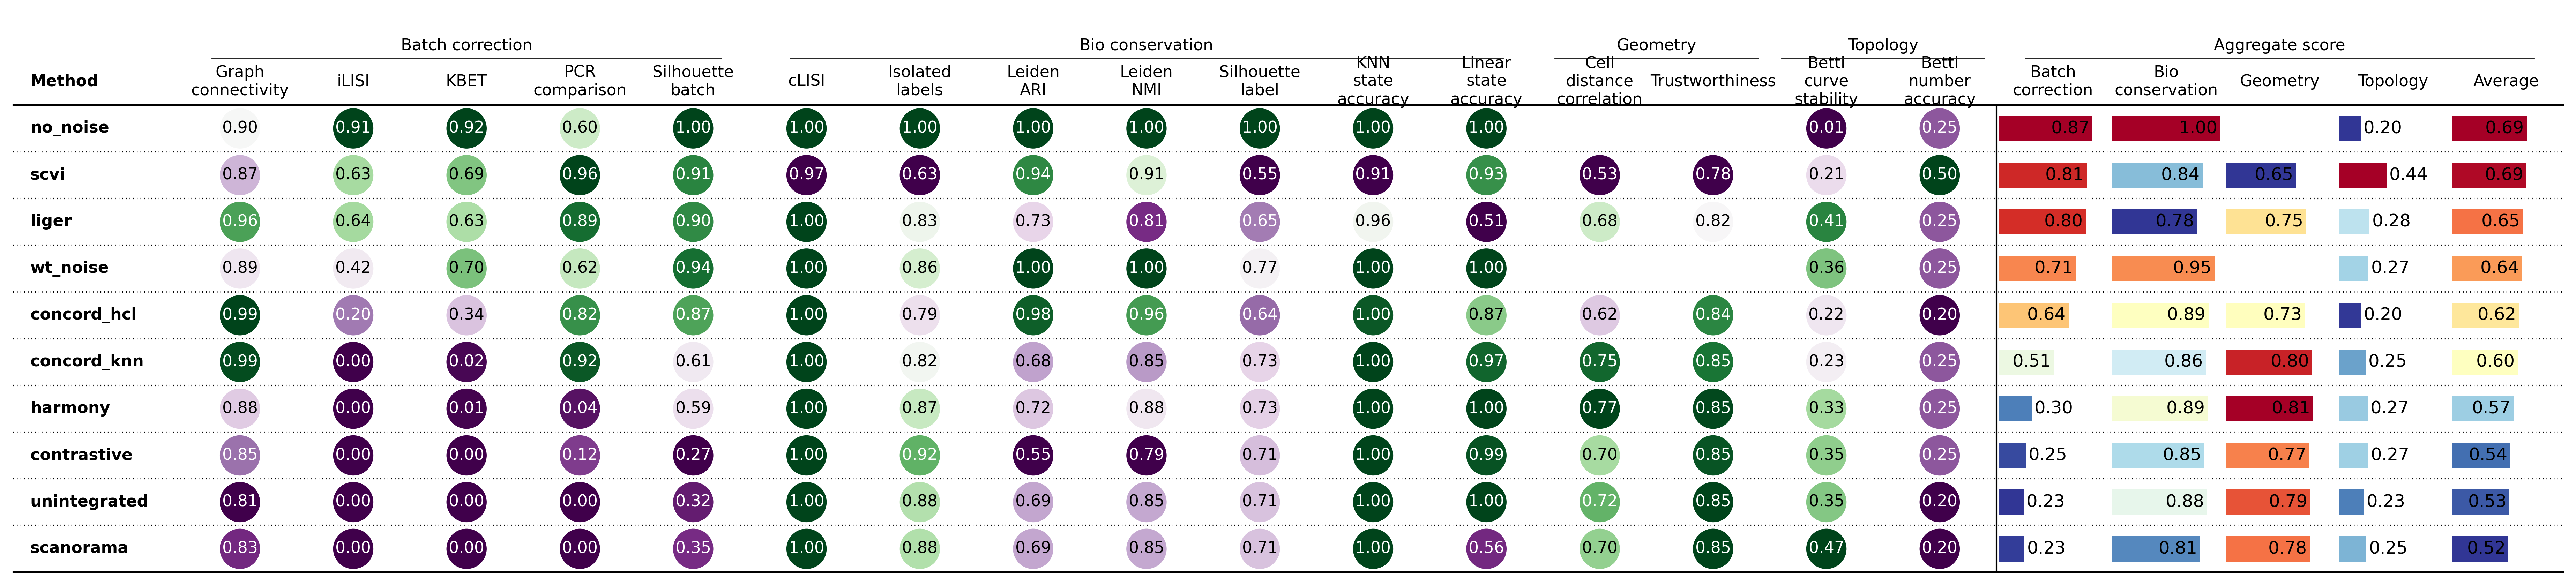

Batch correction                                     \
            Graph connectivity     iLISI      KBET PCR comparison   
no_noise              0.901597  0.905881  0.921671       0.599579   
scvi                  0.870436  0.631581  0.688687       0.963229   
liger                 0.960705  0.635774  0.632322       0.887465   
wt_noise              0.892589  0.419777  0.696482       0.616873   
concord_hcl           0.993486   0.19963  0.337436       0.822347   

                             Bio conservation                             \
            Silhouette batch            cLISI Isolated labels Leiden ARI   
no_noise                 1.0         1.000001             1.0        1.0   
scvi                0.910874         0.971636        0.634017   0.941438   
liger               0.901047              1.0        0.828306    0.73211   
wt_noise            0.938841              1.0        0.856515        1.0   
concord_hcl         0.868033              1.0        0.792897   0.977037   

                                         ...                        \
            Leiden NMI Silhouette label  ... Linear state accuracy   
no_noise           1.0              1.0  ...              1.000000   
scvi          0.911857         0.550509  ...              0.928571   
liger         0.808097         0.650632  ...              0.514286   
wt_noise           1.0         0.767255  ...              1.000000   
concord_hcl   0.964144         0.638262  ...              0.871429   

                             Geometry                              Topology  \
            Cell distance correlation Trustworthiness Betti curve stability   
no_noise                          NaN             NaN              0.013505   
scvi                         0.529369        0.776716              0.207510   
liger                        0.677509        0.815438              0.414389   
wt_noise                          NaN             NaN              0.358530   
concord_hcl                  0.619624        0.844652              0.220108   

                                   Aggregate score                             \
            Betti number accuracy Batch correction Bio conservation  Geometry   
no_noise                     0.25         0.865746         1.000000       NaN   
scvi                         0.50         0.812962         0.835535  0.653042   
liger                        0.25         0.803462         0.784368  0.746474   
wt_noise                     0.25         0.712913         0.946253       NaN   
concord_hcl                  0.20         0.644186         0.891457  0.732138   

                                 
             Topology   Average  
no_noise     0.202701  0.689482  
scvi         0.441502  0.685760  
liger        0.282878  0.654295  
wt_noise     0.271706  0.643624  
concord_hcl  0.204022  0.617951  

[5 rows x 21 columns]

In [104]:
out = ccd.bm.run_benchmark_pipeline(
    adata,
    embedding_keys=combined_keys,
    state_key=state_key,
    batch_key=batch_key,
    groundtruth_key="no_noise",  # use the Leiden clusters as ground truth
    save_dir=save_dir / "benchmarks_out",
    file_suffix=file_suffix,  # e.g. "2025-06-25"
    run=("scib", "probe", "geometry", "topology"),          # run only these blocks
    plot_individual=False,          # skip the intermediate PDFs
    expected_betti_numbers=[4,0,0],  # expected Betti numbers for the geometry and topology blocks
    max_points=1500,
    seed=seed,  # for reproducibility
)
combined = out["combined"]
combined.head()

In [105]:
import pickle
out = pickle.load(open(Path("../save/dev_simulation_cluster_partialoverlap-Jul24/benchmarks_out") / f"benchmark_results_Jul24-1528.pkl", "rb"))
combined = out["combined"]

with open('../save/dev_simulation_cluster_partialoverlap-Jul24/benchmarks_out/topology_diagrams_Jul24-1528.pkl', 'rb') as f:
    diagrams = pickle.load(f)

geometry_full = pickle.load(open(Path("../save/dev_simulation_cluster_partialoverlap-Jul24/benchmarks_out/geometry_results_Jul24-1528.pkl"), "rb"))


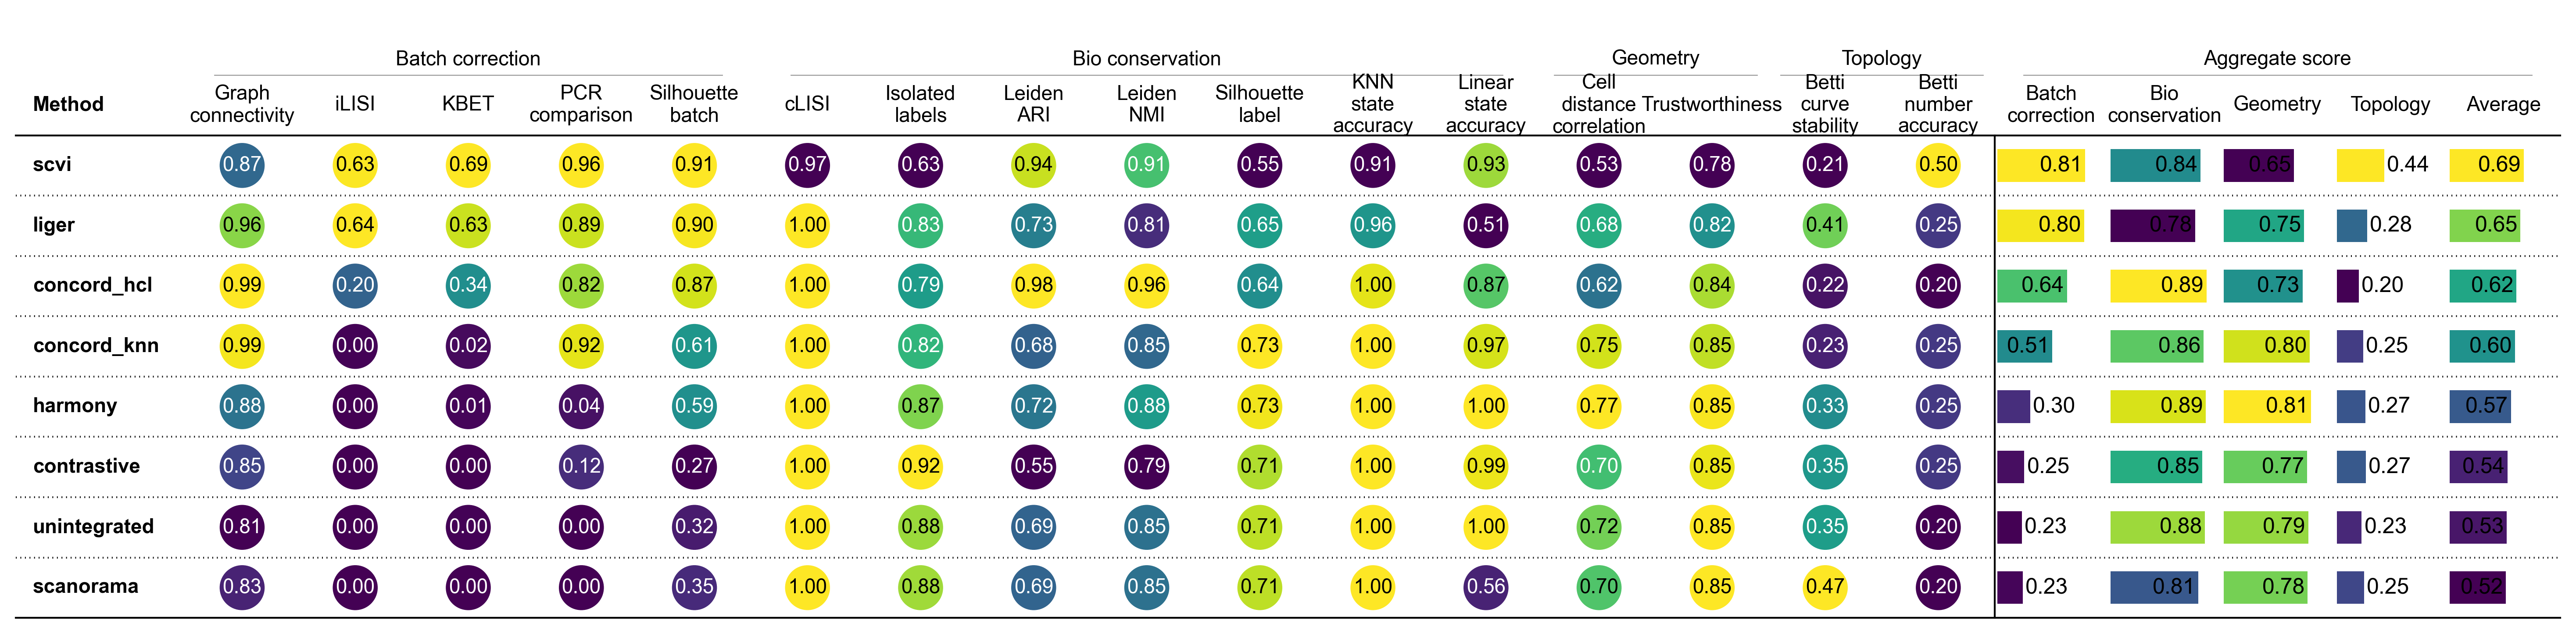

In [106]:
table_plot_kw = dict(
        pal="viridis", pal_agg="viridis", cmap_method="minmax", dpi=300)
with plt.rc_context(rc=custom_rc):
    combined_df = ccd.bm.combine_benchmark_results(
        out,
        block_include=("geometry", "topology", "scib", "probe"),
        plot=False,
        save_path=save_dir / f"combined_res_{file_suffix}.pdf",
        table_plot_kw=table_plot_kw,
    )
    ccd.bm.plot_benchmark_table(
            combined_df.dropna(axis=0, how='any'),
            save_path=save_dir / f"benchmark_table_{file_suffix}.svg",
            agg_name="Aggregate score",
            figsize=(25, 6),
            **table_plot_kw
            )

In [25]:
probe_acc_cols = {"KNN state accuracy", "Linear state accuracy"}

sorted(combined_df.columns,
        key=lambda c: (c[0] == "Aggregate score",
                        c[0],
                        c[1] in probe_acc_cols,
                        str(c[1]).lower()))

[('Batch correction', 'Graph connectivity'),
 ('Batch correction', 'iLISI'),
 ('Batch correction', 'KBET'),
 ('Batch correction', 'PCR comparison'),
 ('Batch correction', 'Silhouette batch'),
 ('Bio conservation', 'cLISI'),
 ('Bio conservation', 'Isolated labels'),
 ('Bio conservation', 'Leiden ARI'),
 ('Bio conservation', 'Leiden NMI'),
 ('Bio conservation', 'Silhouette label'),
 ('Bio conservation', 'KNN state accuracy'),
 ('Bio conservation', 'Linear state accuracy'),
 ('Geometry', 'Cell distance correlation'),
 ('Geometry', 'Trustworthiness'),
 ('Topology', 'Betti curve stability'),
 ('Topology', 'Betti number accuracy'),
 ('Aggregate score', 'Average'),
 ('Aggregate score', 'Batch correction'),
 ('Aggregate score', 'Bio conservation'),
 ('Aggregate score', 'Geometry'),
 ('Aggregate score', 'Topology')]

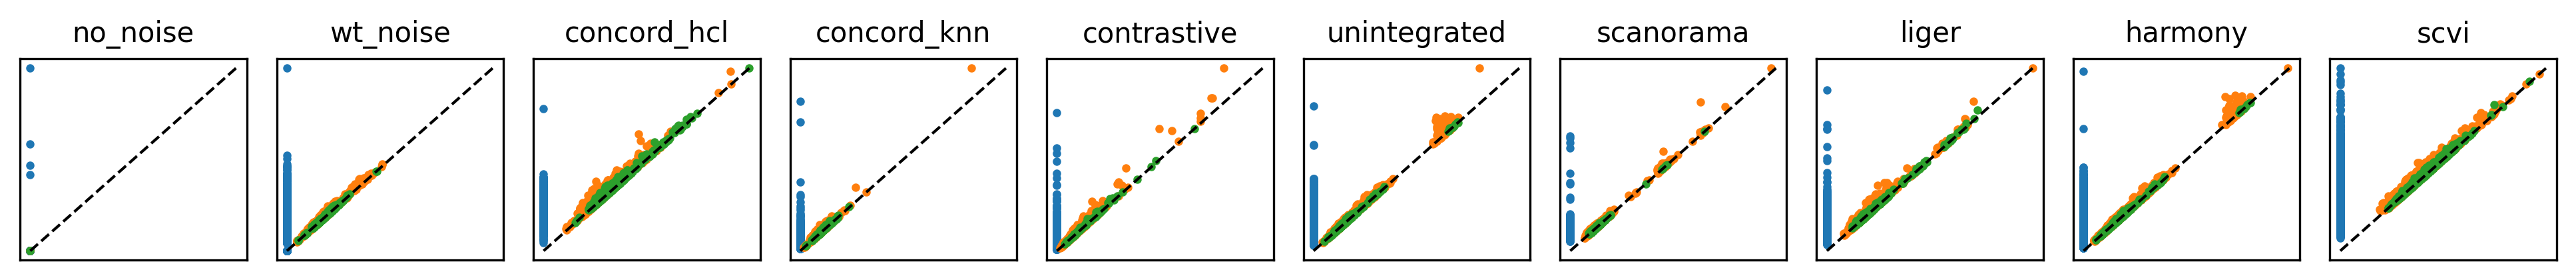

In [23]:
# Reorder diagrams with the same order as the combined keys
diagrams_ordered = {key: diagrams[key] for key in combined_keys}
ccd.pl.plot_persistence_diagrams(diagrams_ordered, base_size=(1.3, 1.5), dpi=300, marker_size=4, n_cols=len(diagrams_ordered), fontsize=10, save_path=save_dir / f"persistence_diagrams_{file_suffix}.pdf", legend=False, label_axes=False, axis_ticks=False)

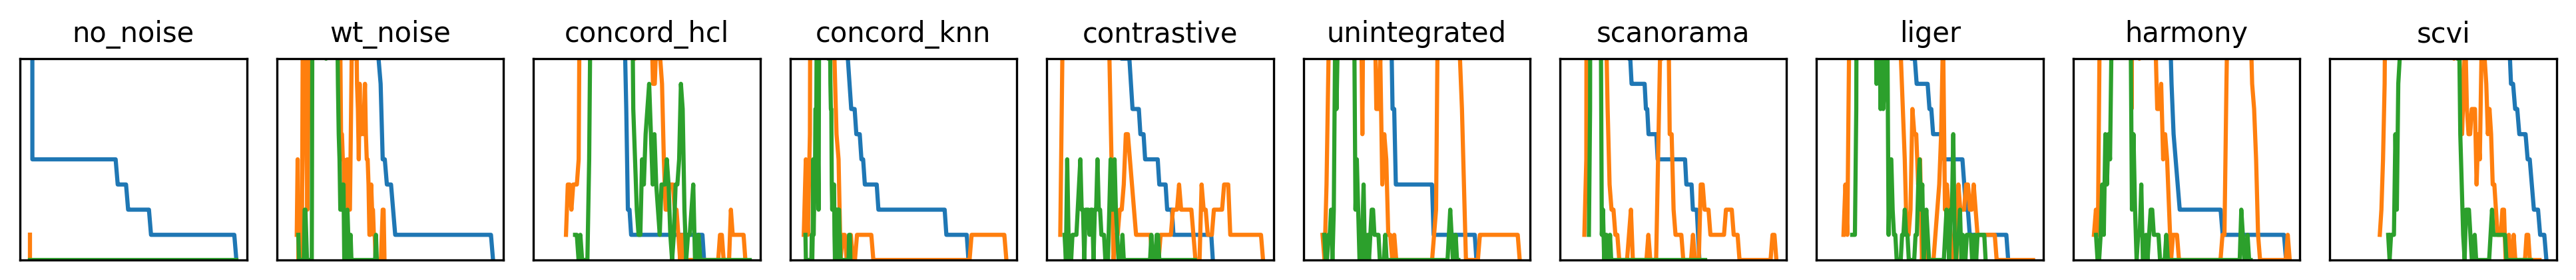

In [24]:
ccd.pl.plot_betti_curves(diagrams_ordered, nbins=100, base_size=(1.3, 1.5), n_cols=len(diagrams_ordered), fontsize=10, save_path=save_dir / f"betti_curves_{file_suffix}.pdf", dpi=300, legend=False, label_axes=False, axis_ticks=False)

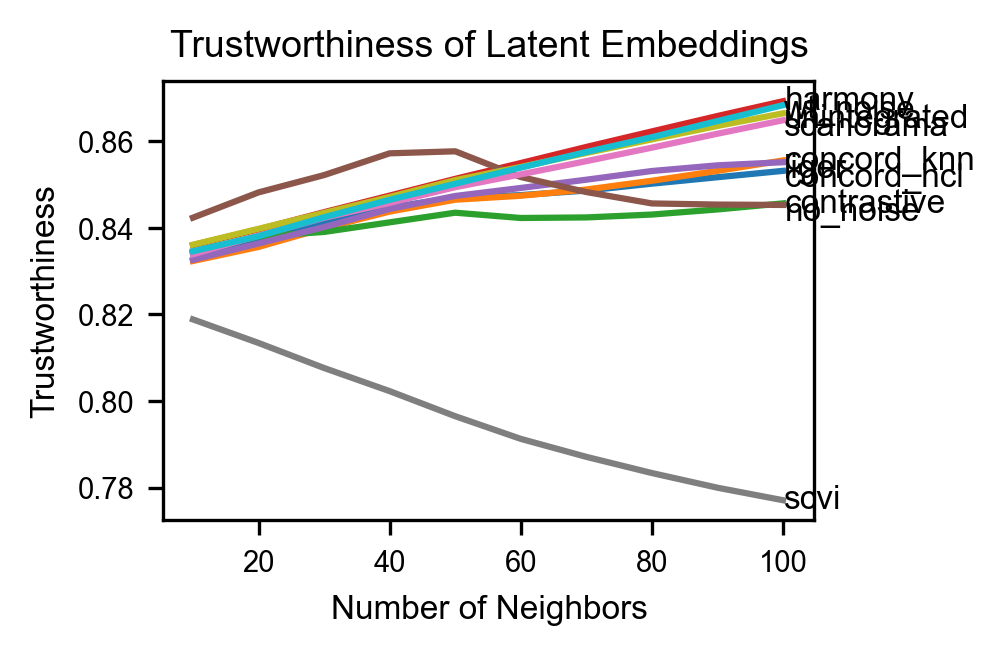

In [25]:
trustworthiness_scores = geometry_full['trustworthiness']['scores']
drop_methods = []
# Drop row with column 'Embedding' in drop_methods
trustworthiness_scores = trustworthiness_scores[~trustworthiness_scores['Embedding'].isin(drop_methods)]
with plt.rc_context(rc=custom_rc):
    ccd.pl.plot_trustworthiness(trustworthiness_scores, text_shift=0.2, min_gap=0.002, legend=False, save_path=save_dir / f"trustworthiness_{file_suffix}.pdf", figsize=(2.8,1.9))

In [26]:
geometry_full['state_dispersion_corr']['correlation']

pearsonr(sv)  spearmanr(sv)  kendalltau(sv)
no_noise          0.940344            0.9             0.8
wt_noise          1.000000            1.0             1.0
concord_hcl       0.596306            0.7             0.6
concord_knn       0.707354            0.8             0.6
contrastive      -0.351971           -0.6            -0.4
unintegrated      0.999362            1.0             1.0
scanorama        -0.717988           -1.0            -1.0
liger            -0.410943           -0.5            -0.2
harmony           0.913836            1.0             1.0
scvi              0.338230            0.5             0.4

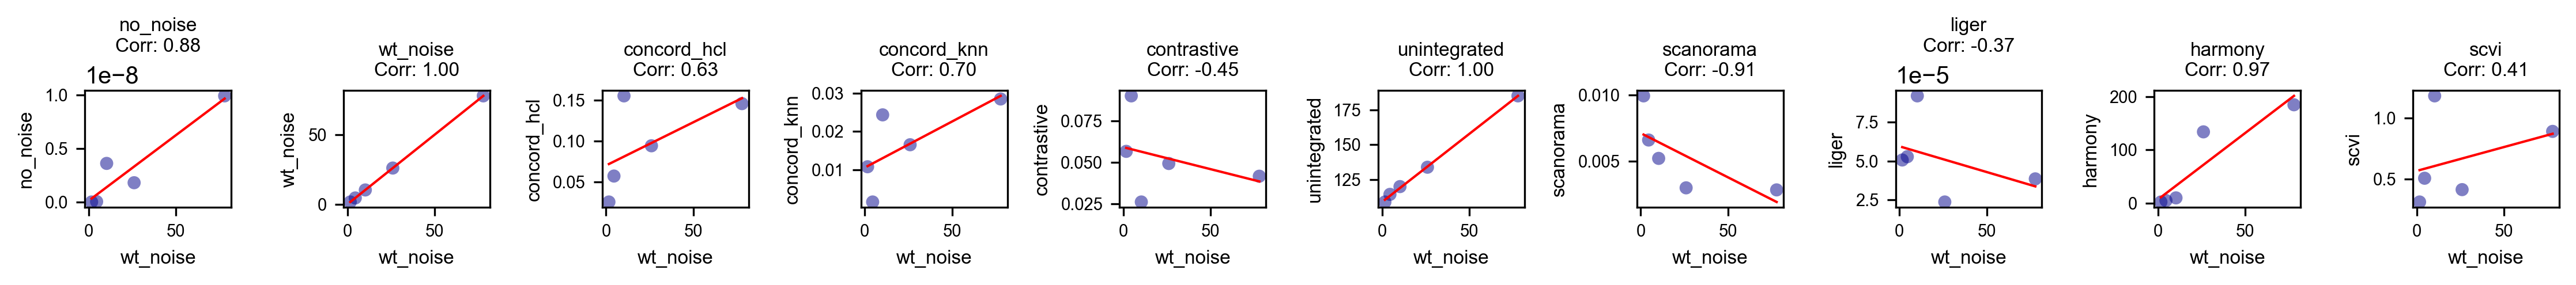

In [30]:
# Drop value with keys in drop_methods from dictionary
import matplotlib.pyplot as plt
dispersion_dict = geometry_full['state_dispersion_corr']['dispersion']
dispersion_dict = {key: dispersion_dict[key] for key in dispersion_dict if key not in drop_methods}
correlation_df = geometry_full['state_dispersion_corr']['correlation'].drop(index=drop_methods)
with plt.rc_context(rc=custom_rc):
    ccd.pl.plot_geometry_scatter(
        data_dict = dispersion_dict,
        correlation= correlation_df,
        s=30, c='darkblue',
        ground_key = 'wt_noise',
        linear_fit = True,
        n_cols = len(dispersion_dict), figsize=(1.5,1.75), dpi=300, save_path=save_dir / f"state_dispersion_scatter_{file_suffix}.pdf")

### 2.0 Decoder reconstruction (if concord is run with decoder)

In [ ]:
adata.layers

In [ ]:
# Align and copy the layer data based on observation names
adata.layers['no_noise'] = np.zeros_like(adata.X)

# Find the indices of common genes between `adata` and `adata_state`
common_genes = adata.var_names.intersection(adata_state.var_names)
adata_indices = adata.var_names.get_indexer(common_genes)
adata_state_indices = adata_state.var_names.get_indexer(common_genes)

# Copy data from `adata_state` to `adata` for these common genes
adata.layers['no_noise'][:, adata_indices] = adata_state.layers['no_noise'][:, adata_state_indices].copy()

decoded_layers = ['Concord-decoder_decoded_batch_1', 'Concord-decoder_decoded_batch_2']
show_layers = ['no_noise', 'wt_noise'] + decoded_layers
ccd.pl.plot_adata_layer_heatmaps(adata, ncells=None, ngenes=None, layers=show_layers, cmap='viridis', vmin=0, vmax=7, 
                                 obs_keys=[state_key, batch_key], transpose=False, figsize=(6,6),  dpi=300, save_path=save_dir/f'decoded_heatmap_{file_suffix}.png')

In [ ]:
# Compute the reconstruction error between the original and reconstructed data
mse_no_noise = np.zeros(len(decoded_layers))
mse_wt_noise = np.zeros(len(decoded_layers))
state_genes = adata.var_names[adata.var_names.isin(adata_state.var_names)]
for layer in decoded_layers:
    mse_no_noise[decoded_layers.index(layer)] = ccd.ul.compute_reconstruction_error(adata[:,state_genes], 'no_noise', layer, metric='mse')
    mse_wt_noise[decoded_layers.index(layer)] = ccd.ul.compute_reconstruction_error(adata[:,state_genes], 'wt_noise', layer, metric='mse')

# Report value, mean
print(f"MSE between no_noise and decoded layers: {mse_no_noise}")
print(f"MSE between wt_noise and decoded layers: {mse_wt_noise}")
print(f"Mean MSE between no_noise and decoded layers: {np.mean(mse_no_noise):.4f}")
print(f"Mean MSE between wt_noise and decoded layers: {np.mean(mse_wt_noise):.4f}")
